## learning-AI101 : glass classification (DL)
### 유리 데이터를 Dense layer struction을 통한 DNN 방식 및 CNN으로의 classification

<br>

- **임규연 (lky473736)**
- 2024.08.04. ~ 2024.08.06. 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/42/glass+identification
- **kaggle** : https://www.kaggle.com/datasets/uciml/glass
- **data abstract** : Vina conducted a comparison test of her rule-based system, BEAGLE, the nearest-neighbor algorithm, and discriminant analysis.  BEAGLE is a product available through VRS Consulting, Inc.; 4676 Admiralty Way, Suite 206; Marina Del Ray, CA 90292 (213) 827-7890 and FAX: -3189. In determining whether the glass was a type of "float" glass or not. The study of classification of types of glass was motivated by criminological investigation.  At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!

------



## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 glass을 classification한다. 목차는 아래와 같다.

- **1. 데이터 분석, 시각화 및 전처리**
- **2. SGDClassifier를 통한 ML에서의 확률적 경사 하강법 적용**
- **3. ANN (fully connected)**
- **4. DNN**
- **5. CNN**


In [5]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

------

### 1. 데이터 분석, 시각화 및 전처리
- 데이터 로드 및 필요한 정보, 기초통계량을 get한다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- cell 순서는 아래와 같다.
    - (1) 데이터 읽기 및 head 파악
    - (2) 데이터 info (결측치 파악), 데이터 크기
    - (3) 데이터 기초통계량 확인 
    - (4) heatmap 
    - (5) feature, target data split, target countplot
        - 저번 ./DL_regression_glass.ipynb에서는 feature selection을 통하여 특정 feature를 X로 두었다. 이번에는 target을 조정한다.
            - 추후 데이터 info를 보면서 각 feature 및 target에 대한 설명을 덧붙일 것이지만, 현재 target을 크게 분류하면 다음과 같다.
                - 1, 2 : 빌딩 창문
                - 3, 4 : 자동차 창문 (이때, 4는 아예 존재 x)
                - 5 : 컨테이너 창문
                - 6, 7 : 소형 물건
            - 따라서 원래 6개의 target을 4개로 조정할 계획이다.
    - (6) train set, test set, validation set split 
    - (7) input data : apply PolynormialFeature 
    - (8) scaling (z-score normalization)

In [6]:
# (1) 데이터 읽기 및 head 파악

columns = ['id', 'RI', 'Na', 'Mg', 
          'Al', 'Si', 'K', 'Ca', 
          'Ba', 'Fe', 'target']
df = pd.read_csv("../../data/glass/glass.csv", names=columns)
df.head()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,target
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [7]:
# (2) 데이터 info (결측치 파악), 데이터 크기

print('dataframe size : ', df.shape)
df.info()

dataframe size :  (214, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      214 non-null    int64  
 1   RI      214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  target  214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


각 attribute가 의미하는 바는 아래와 같다.

- **id**: 각 샘플에 대한 고유 식별자이다.
- **RI (Refractive Index)**: 유리의 굴절률을 나타낸다.
- **Na (Sodium)**: 유리에 포함된 나트륨의 산화물 비율(%)을 나타낸다.
- **Mg (Magnesium)**: 유리에 포함된 마그네슘의 산화물 비율(%)을 나타낸다.
- **Al (Aluminum)**: 유리에 포함된 알루미늄의 산화물 비율(%)을 나타낸다.
- **Si (Silicon)**: 유리에 포함된 실리콘의 산화물 비율(%)을 나타낸다.
- **K (Potassium)**: 유리에 포함된 칼륨의 산화물 비율(%)을 나타낸다.
- **Ca (Calcium)**: 유리에 포함된 칼슘의 산화물 비율(%)을 나타낸다.
- **Ba (Barium)**: 유리에 포함된 바륨의 산화물 비율(%)을 나타낸다.
- **Fe (Iron)**: 유리에 포함된 철의 산화물 비율(%)을 나타낸다.
- **target**: 유리의 종류를 나타내는 목표 변수이다.

In [8]:
# (3) data 기초통계량 확인

df.describe()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,target
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


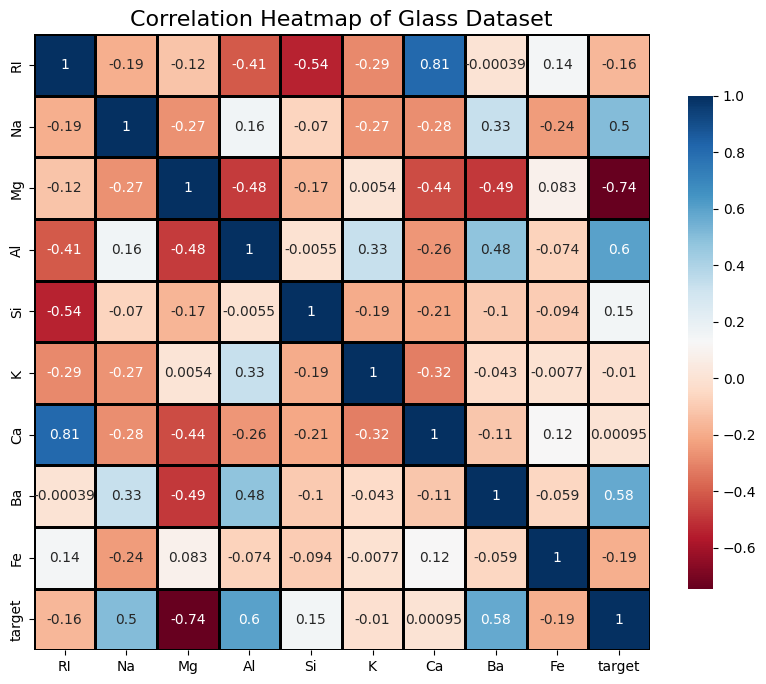

In [9]:
# (4) heatmap

# id 열은 제외
correlation_matrix = df[['RI', 'Na', 'Mg', 
                         'Al', 'Si', 'K', 
                         'Ca', 'Ba', 'Fe', 'target']].corr() 
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Glass Dataset', fontsize=16)
plt.show()

(214, 9) (214,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


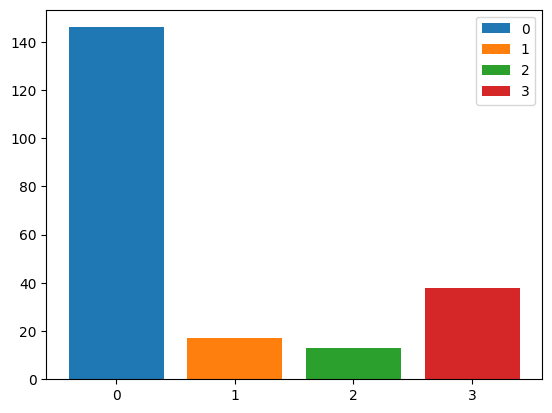

In [10]:
# (5) feature, input data split, target countplot

glass_input = df[['RI', 'Na', 'Mg', 
          'Al', 'Si', 'K', 'Ca', 
          'Ba', 'Fe']].to_numpy() # id 열을 제외함
glass_target = df['target'].to_numpy()

# glass_target를 redesign
'''
1, 2 : 빌딩 창문 (0) 
3, 4 : 자동차 창문 (이때, 4는 아예 존재 x) (1)
5 : 컨테이너 창문 (2) 
6, 7 : 소형 물건 (3)
'''
for i in range (len(glass_target)) :
    compo = glass_target[i]
    
    if compo in [1, 2] :
        glass_target[i] = 0
        
    elif compo in [3, 4] :
        glass_target[i] = 1
        
    elif compo == 5 : 
        glass_target[i] = 2
    
    else : 
        glass_target[i] = 3

print (glass_input.shape, glass_target.shape)
print (glass_target)

# countplot 시각화

plt.bar ('0', len([compo for compo in glass_target if compo == 0]), label='0')
plt.bar ('1', len([compo for compo in glass_target if compo == 1]), label='1')
plt.bar ('2', len([compo for compo in glass_target if compo == 2]), label='2')
plt.bar ('3', len([compo for compo in glass_target if compo == 3]), label='3')
plt.legend()
plt.show()

In [11]:
# (6) train set, test set, validation set split, scaling (z-score normalization)

# X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(glass_input, 
                                                   glass_target,
                                                   test_size=0.2)

# X_train, y_train, X_test, y_test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=0.2)

In [12]:
# (7) input data : PolynormialFeature 

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2) # 2차까지
poly.fit(X_train)

X_train_poly = poly.transform (X_train)
X_test_poly = poly.transform (X_test)
X_val_poly = poly.transform (X_val )

print (f"shape | X_train_poly : {X_train_poly.shape}, X_test_poly : {X_test_poly.shape}, X_val_poly : {X_val_poly.shape}")
print (f"poly | {poly.get_feature_names_out()}")

shape | X_train_poly : (136, 55), X_test_poly : (43, 55), X_val_poly : (35, 55)
poly | ['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x0^2' 'x0 x1' 'x0 x2'
 'x0 x3' 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x0 x8' 'x1^2' 'x1 x2' 'x1 x3'
 'x1 x4' 'x1 x5' 'x1 x6' 'x1 x7' 'x1 x8' 'x2^2' 'x2 x3' 'x2 x4' 'x2 x5'
 'x2 x6' 'x2 x7' 'x2 x8' 'x3^2' 'x3 x4' 'x3 x5' 'x3 x6' 'x3 x7' 'x3 x8'
 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7' 'x4 x8' 'x5^2' 'x5 x6' 'x5 x7' 'x5 x8'
 'x6^2' 'x6 x7' 'x6 x8' 'x7^2' 'x7 x8' 'x8^2']


In [13]:
# (8) scaling

# normal data scaling
ss_transformer = StandardScaler()
ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)
X_val_scaled = ss_transformer.transform(X_val)

# polynormial data scaling
ss_transformer = StandardScaler()
ss_transformer.fit(X_train_poly)

X_train_poly_scaled = ss_transformer.transform(X_train_poly)
X_test_poly_scaled = ss_transformer.transform(X_test_poly)
X_val_poly_scaled = ss_transformer.transform(X_val_poly)

-------

### 2. SGDClassifier 통한 ML에서의 확률적 경사 하강법 적용
deep learning을 하기 전, deep learning의 weight 및 bias 조정법인 **SGD (Stochastic Gradient Descent)** 를 scikit-learn으로 구현해본다. parameter는 random search를 통하여 최적화할 것이며, 자세한 조정범위는 아래에 서술한다.
- loss function : hinge loss function (One vs Rest 방식으로 사용)
- max_iter : 3~50 (randint)

poly set과 normal set을 비교하여 둘 중 앞으로 무슨 dataset을 사용할 지를 결정한다.

In [14]:
# random search를 통한 hyperparameter tuning
# ConvergenceWarning을 방지함

from sklearn.linear_model import SGDClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings

param = {
    'max_iter': randint(3, 50)
}

sr_1 = SGDClassifier(loss='hinge', max_iter=1000)
sr_2 = SGDClassifier(loss='hinge', max_iter=1000)

rs_1 = RandomizedSearchCV(sr_1, param, n_iter=50, n_jobs=-1)
rs_2 = RandomizedSearchCV(sr_2, param, n_iter=50, n_jobs=-1)

with warnings.catch_warnings() :
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    rs_1.fit(X_train_scaled, y_train)
    
with warnings.catch_warnings() :
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    rs_2.fit(X_train_poly_scaled, y_train)

print ("best params for rs_1 :", rs_1.best_params_)
print ("best params for rs_2 :", rs_2.best_params_)
print ("best score for rs_1 :", rs_1.best_score_)
print ("best score for rs_2 :", rs_2.best_score_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reache

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reache

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reache

best params for rs_1 : {'max_iter': 38}
best params for rs_2 : {'max_iter': 33}
best score for rs_1 : 0.8306878306878305
best score for rs_2 : 0.8597883597883598


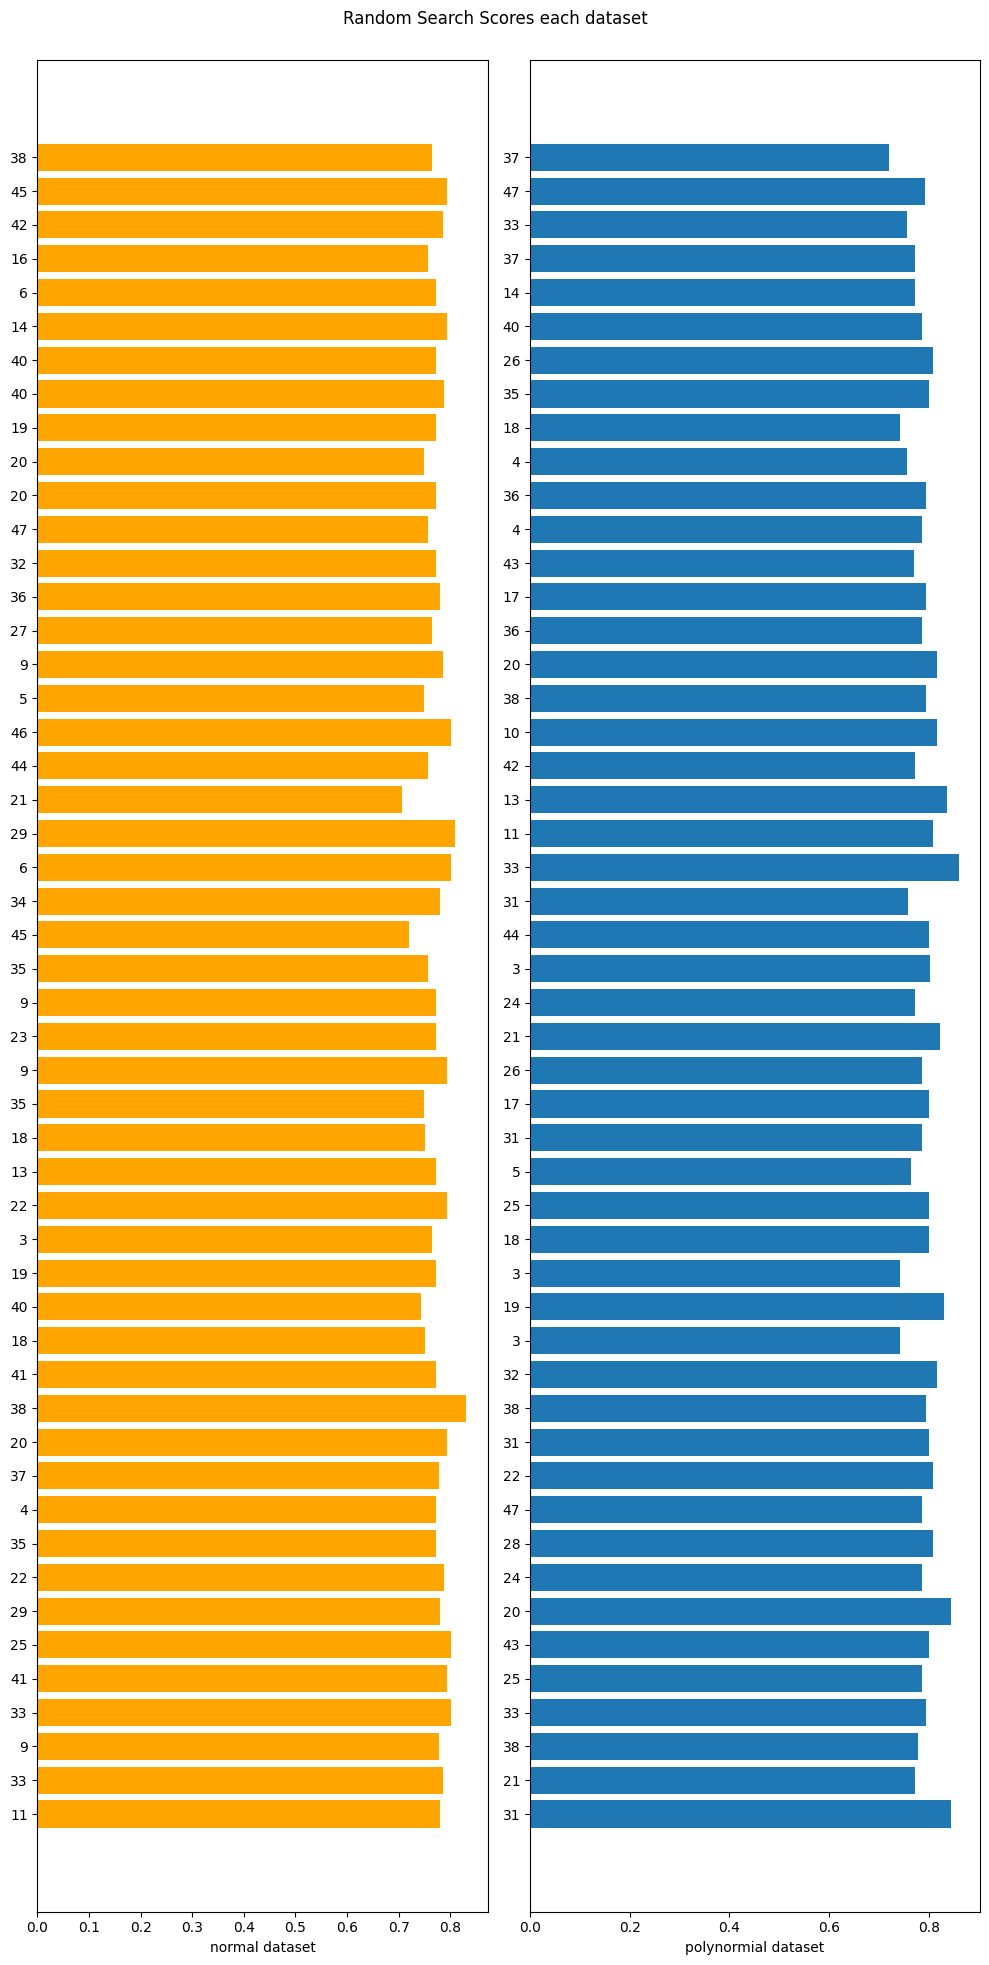

In [15]:
# 하이퍼파라미터 조합별 성능 시각화
# subplot을 도입

fig, axes = plt.subplots(1, 2, figsize=(10, 20))

plt.suptitle('Random Search Scores each dataset\n\n')

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results_1 = rs_1.cv_results_
mean_scores_1 = results_1['mean_test_score']
params_1 = results_1['params']

results_2 = rs_2.cv_results_
mean_scores_2 = results_2['mean_test_score']
params_2 = results_2['params']

# 시각화를 위한 데이터 준비
max_iter_values_1 = [params_1[i]['max_iter'] for i in range(len(params_1))]
max_iter_values_2 = [params_2[i]['max_iter'] for i in range(len(params_2))]

bars_1 = axes[0].barh(range(len(mean_scores_1)), mean_scores_1, 
                    tick_label=[f"{compo}" for compo in max_iter_values_1], color='orange')
bars_2 = axes[1].barh(range(len(mean_scores_2)), mean_scores_2, 
                    tick_label=[f"{compo}" for compo in max_iter_values_2])

axes[0].set_xlabel('normal dataset')
axes[1].set_xlabel('polynormial dataset')
plt.tight_layout()
plt.show()

In [16]:
# best score, best model, train score, test score

sr_1 = rs_1.best_estimator_
print ("rs_1 (normal dataset)")
print ("best score : ", rs_1.best_score_)
print ("best estimator (model) : ", sr_1)

sr_1_score = [sr_1.score(X_train_scaled, y_train), sr_1.score(X_test_scaled, y_test),
             sr_1.score(X_val_scaled, y_val)]
print (f"train score, test score, val score : {sr_1_score}")

print ()

sr_2 = rs_2.best_estimator_
print ("rs_2 (polynormial dataset)")
print ("best score : ", rs_2.best_score_)
print ("best estimator (model) : ", sr_2)

sr_2_score = [sr_2.score(X_train_poly_scaled, y_train), sr_2.score(X_test_poly_scaled, y_test),
             sr_2.score(X_val_poly_scaled, y_val)]
print (f"train score, test score, val score : {sr_2_score}")

rs_1 (normal dataset)
best score :  0.8306878306878305
best estimator (model) :  SGDClassifier(max_iter=38)
train score, test score, val score : [0.8308823529411765, 0.6744186046511628, 0.8285714285714286]

rs_2 (polynormial dataset)
best score :  0.8597883597883598
best estimator (model) :  SGDClassifier(max_iter=33)
train score, test score, val score : [0.8823529411764706, 0.7674418604651163, 0.8]


rs_1 (normal dataset)

report :
               precision    recall  f1-score   support

           0       0.86      0.73      0.79        33
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.62      1.00      0.77         5

    accuracy                           0.67        43
   macro avg       0.37      0.43      0.39        43
weighted avg       0.73      0.67      0.69        43

[[24  4  3  2]
 [ 3  0  0  0]
 [ 1  0  0  1]
 [ 0  0  0  5]]


rs_2 (polynormial dataset)

report :
               precision    recall  f1-score   support

           0       0.96      0.77      0.86        35
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           3       0.75      1.00      0.86         6

    accuracy                           0.77        43
   macro avg       0.43      0.44      0.43        43
weighted avg       0.89      0.77      0.82        

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

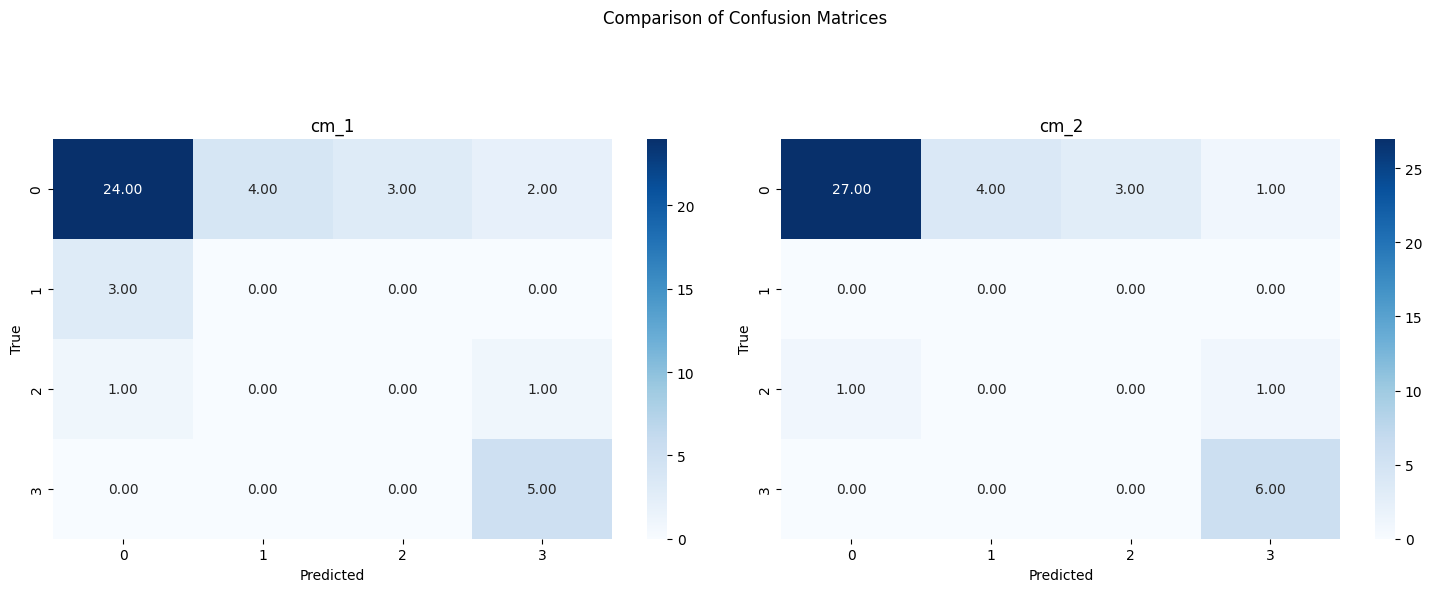

In [17]:
# report 및 confusion matrix 시각화

from sklearn.metrics import confusion_matrix, classification_report

y_pred_1 = rs_1.predict(X_test_scaled)
y_pred_2 = rs_2.predict(X_test_poly_scaled)
cm_1 = confusion_matrix(y_pred_1, y_test)
cm_2 = confusion_matrix(y_pred_2, y_test)

print ("rs_1 (normal dataset)")
print ()
print("report :\n", classification_report(y_pred_1, y_test))
print (cm_1)

print ()
print ()

print ("rs_2 (polynormial dataset)")
print ()
print("report :\n", classification_report(y_pred_2, y_test))
print (cm_2)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 첫 번째 heatmap
sns.heatmap(cm_1, annot=True, cmap='Blues', ax=axes[0], fmt='.2f')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('cm_1')

# 두 번째 heatmap
sns.heatmap(cm_2, annot=True, cmap='Blues', ax=axes[1], fmt='.2f')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('cm_2')

fig.suptitle('Comparison of Confusion Matrices\n\n')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

위 figure를 확인해보았을 때, 아래와 같은 결론을 낼 수 있다.
- **PolynormialFeature, 즉 feature의 수를 feature 내적 통해 늘린 dataset의 score가 normal dataset의 score보다 높지 않다.**
- 현재 target **'0'에 데이터가 밀집되어 있기 때문에** 편향된 confusion matrix가 발생한 것을 확인 가능하다. (countplot 참고)

따라서 feature를 추가할 필요 없이, 기존 X_train_scaled dataset으로 앞으로의 fitting을 진행한다.

-------

### 3.  ANN (fully connected)
- hidden layer를 구성하지 않고, 입력층과 출력층만 존재하는 인공신경망을 struction할 것이다.
- 기존 train set에서 validation set을 하나 더 구성하였고, 추후 evaluation에 사용할 예정이다.
- 출력층의 activation은 softmax를 사용
- compile 시 loss function은 sparse_categorical_crossentropy를 사용한다. (one-hot encoding을 진행하지 않는다.)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            40 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40 (160.00 B)

 Trainable params: 40 (160.00 B)

 Non-trainable params: 0 (0.00 B)

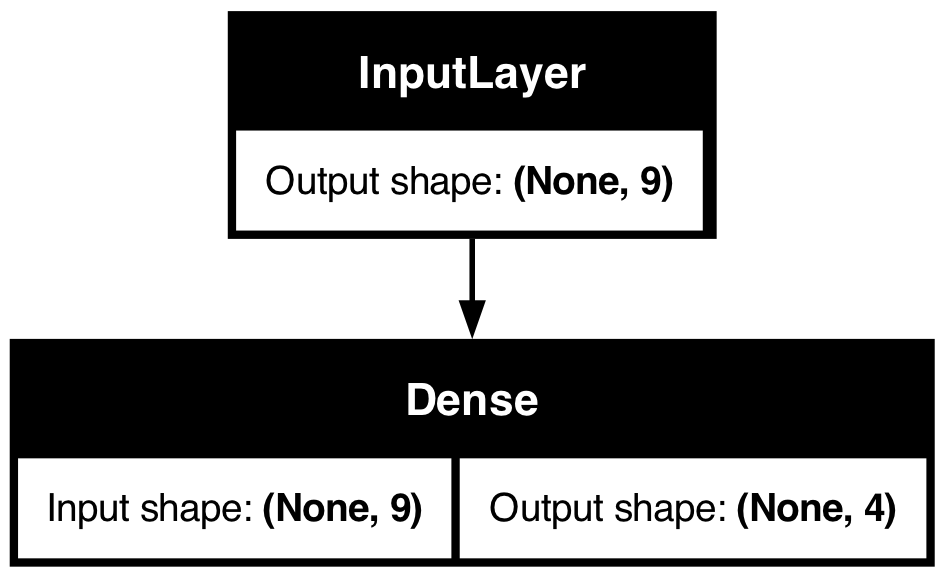

In [18]:
# modelling (functional API)

input_layer = keras.Input(shape=(9, ))
output_layer = keras.layers.Dense(4, activation='softmax')(input_layer) # target의 갯수를 6개에서 4개로 줄여놓음
model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [19]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# fit 

history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), batch_size=10, 
                    # callbacks=early_stopping_cb, 
                    verbose=True)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1968 - loss: 1.7113 - val_accuracy: 0.2571 - val_loss: 1.8654
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2436 - loss: 1.7393 - val_accuracy: 0.2857 - val_loss: 1.8190
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3161 - loss: 1.5849 - val_accuracy: 0.3429 - val_loss: 1.7735
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3453 - loss: 1.6283 - val_accuracy: 0.3714 - val_loss: 1.7287
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2871 - loss: 1.6764 - val_accuracy: 0.3714 - val_loss: 1.6876
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3540 - loss: 1.5245 - val_accuracy: 0.4000 - val_loss: 1.6458
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3608 - loss: 1.4862 - val_accuracy: 0.4286 - val_loss: 1.6065
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3964 - loss: 1.3958 - val_accuracy: 0.4286 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.6700 - val_accuracy: 0.8857 - val_loss: 0.8212
Epoch 52/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8603 - loss: 0.6559 - val_accuracy: 0.8571 - val_loss: 0.8159
Epoch 53/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8051 - loss: 0.6842 - val_accuracy: 0.8571 - val_loss: 0.8099
Epoch 54/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8432 - loss: 0.6275 - val_accuracy: 0.8571 - val_loss: 0.8043
Epoch 55/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8177 - loss: 0.6616 - val_accuracy: 0.8571 - val_loss: 0.7999
Epoch 56/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8804 - loss: 0.5983 - val_accuracy: 0.8571 - val_loss: 0.7947
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8498 - loss: 0.6149 - val_accuracy: 0.8571 - val_loss: 0.7907
Epoch 58/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9117 - loss: 0.5228 - val_accuracy: 0.8571 - val_lo

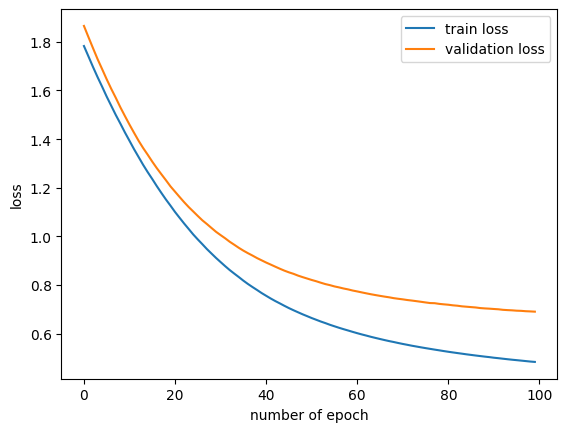

In [21]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

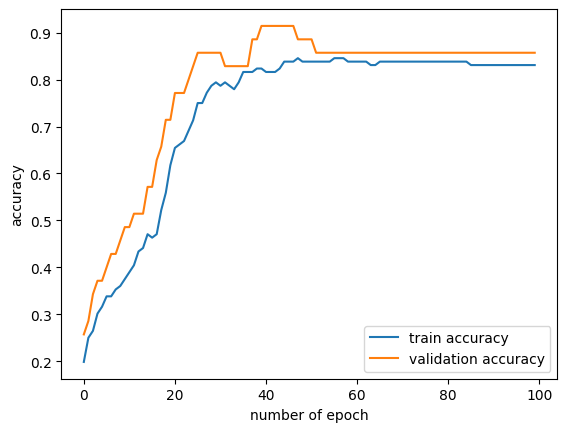

In [22]:
# accuracy 시각화

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.legend (['train accuracy', 'validation accuracy'])
plt.show() 

fitting이 아주 잘된 모범 사례처럼, **loss를 visualization한 figure가 매우 아름답다.** DNN의 성능이 기대된다.
- 참고로, 그동안 accuracy를 기준으로 model의 성능을 파악하고 tuning한 적이 많은데, 앞으로는 loss를 기준으로 처리한다.
- 딥러닝 훈련에서는 손실 함수를 줄이는 것이 우선적이기 때문, 손실 함수는 모델의 예측과 실제 값 간의 차이를 측정하므로, 손실 함수의 최소화가 모델 성능 향상에 직접적으로 기여함

In [23]:
# train score, test score, val score

model_score = [model.evaluate(X_train_scaled, y_train), model.evaluate(X_test_scaled, y_test),
             model.evaluate(X_val_scaled, y_val)]
print (f"train score, test score, val score : {model_score}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8099 - loss: 0.5043 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7512 - loss: 0.6725 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8631 - loss: 0.6894 
train score, test score, val score : [[0.48276907205581665, 0.8308823704719543], [0.6396424174308777, 0.7674418687820435], [0.6909129619598389, 0.8571428656578064]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
***********ANN***********

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
predict result :  [[9.11388695e-01 3.57938409e-02 2.88990717e-02 2.39182916e-02]
 [8.50484610e-01 1.17301457e-01 1.21798115e-02 2.00341064e-02]
 [7.10627019e-01 1.87825844e-01 2.83606350e-02 7.31864423e-02]
 [7.50365913e-01 1.01642281e-01 7.89522827e-02 6.90394491e-02]
 [6.51000082e-01 1.58909351e-01 6.20728619e-02 1.28017619e-01]
 [7.04102755e-01 1.39767438e-01 4.53916155e-02 1.10738195e-01]
 [7.86836565e-01 1.75676242e-01 8.90514906e-03 2.85820942e-02]
 [1.59565527e-02 1.07718315e-02 2.21358359e-01 7.51913309e-01]
 [5.08875310e-01 1.19500801e-01 2.59091198e-01 1.12532631e-01]
 [7.31463850e-01 2.81193312e-02 1.59212232e-01 8.12046081e-02]
 [7.32084632e-01 1.41728139e-02 2.26306930e-01 2.74355784e-02]
 [8.98261845e-01 5.86578175e-02 3.64662707e-02 6.61409460e-03]
 [5.35281718e-01 1.59985691e-01 8.75651911e-02 2.17167377e-01]
 [6.96575046e-01 1.73231333e-01 4.54292074e-02 8.47643614e-0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

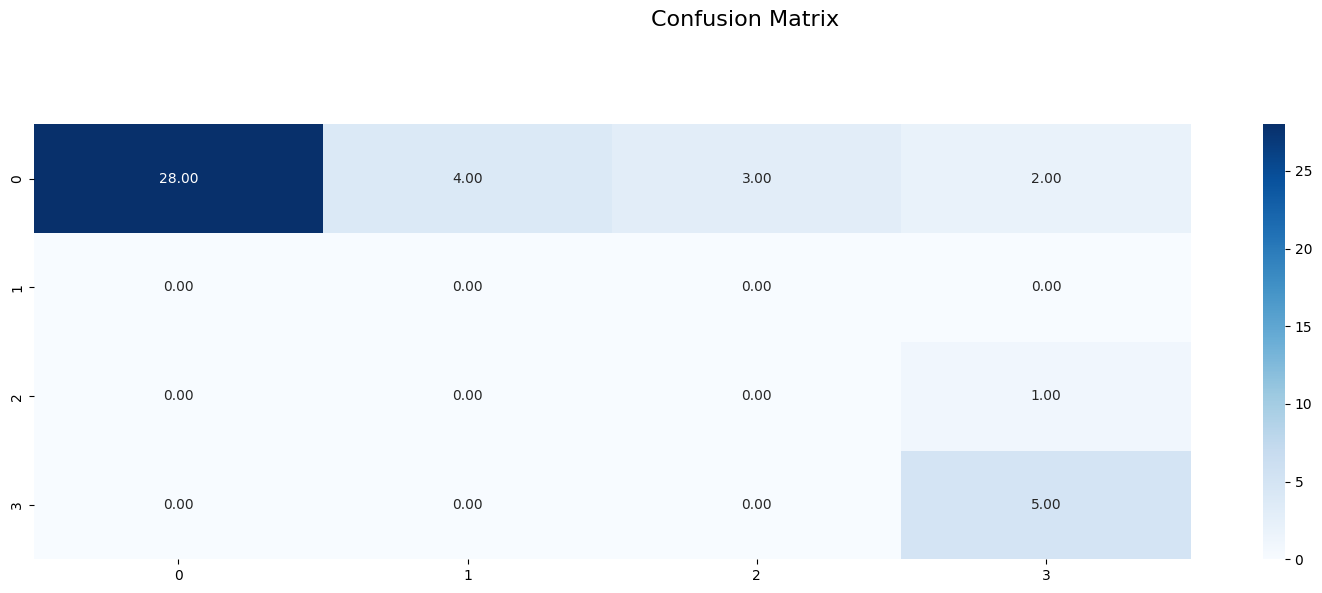

In [24]:
# classification report and confusion matrix (시각화)

y_pred = model.predict(X_test_scaled).argmax(axis=1) # 기억할 것, predict의 결과는 class별로의 확률
cm = confusion_matrix(y_pred, y_test)

print ("***********ANN***********")
print ()
print ("predict result : ", model.predict(X_test_scaled))
print ()
print("report :\n", classification_report(y_pred, y_test))
print (cm_1)

fig, axes = plt.subplots(figsize=(15, 6))

# heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')

fig.suptitle('Confusion Matrix\n\n', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

-------

### 4. DNN 
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - parameter는 최소한 10000개 이상으로 증폭, 각 node의 activation은 relu 사용
    - epoch는 200으로 고정
- 아래와 같이 experiment할 예정이다.
    - optimizer는 **적응형 학습율 optimizer인 adam을 사용한다.**
    - validation loss 감소를 위하여 **dropout 층을 추가 후, callback으로 early stopping을 도입**한다.
        - patiences는 5로 한다.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,420 (13.36 KB)

 Trainable params: 3,420 (13.36 KB)

 Non-trainable params: 0 (0.00 B)

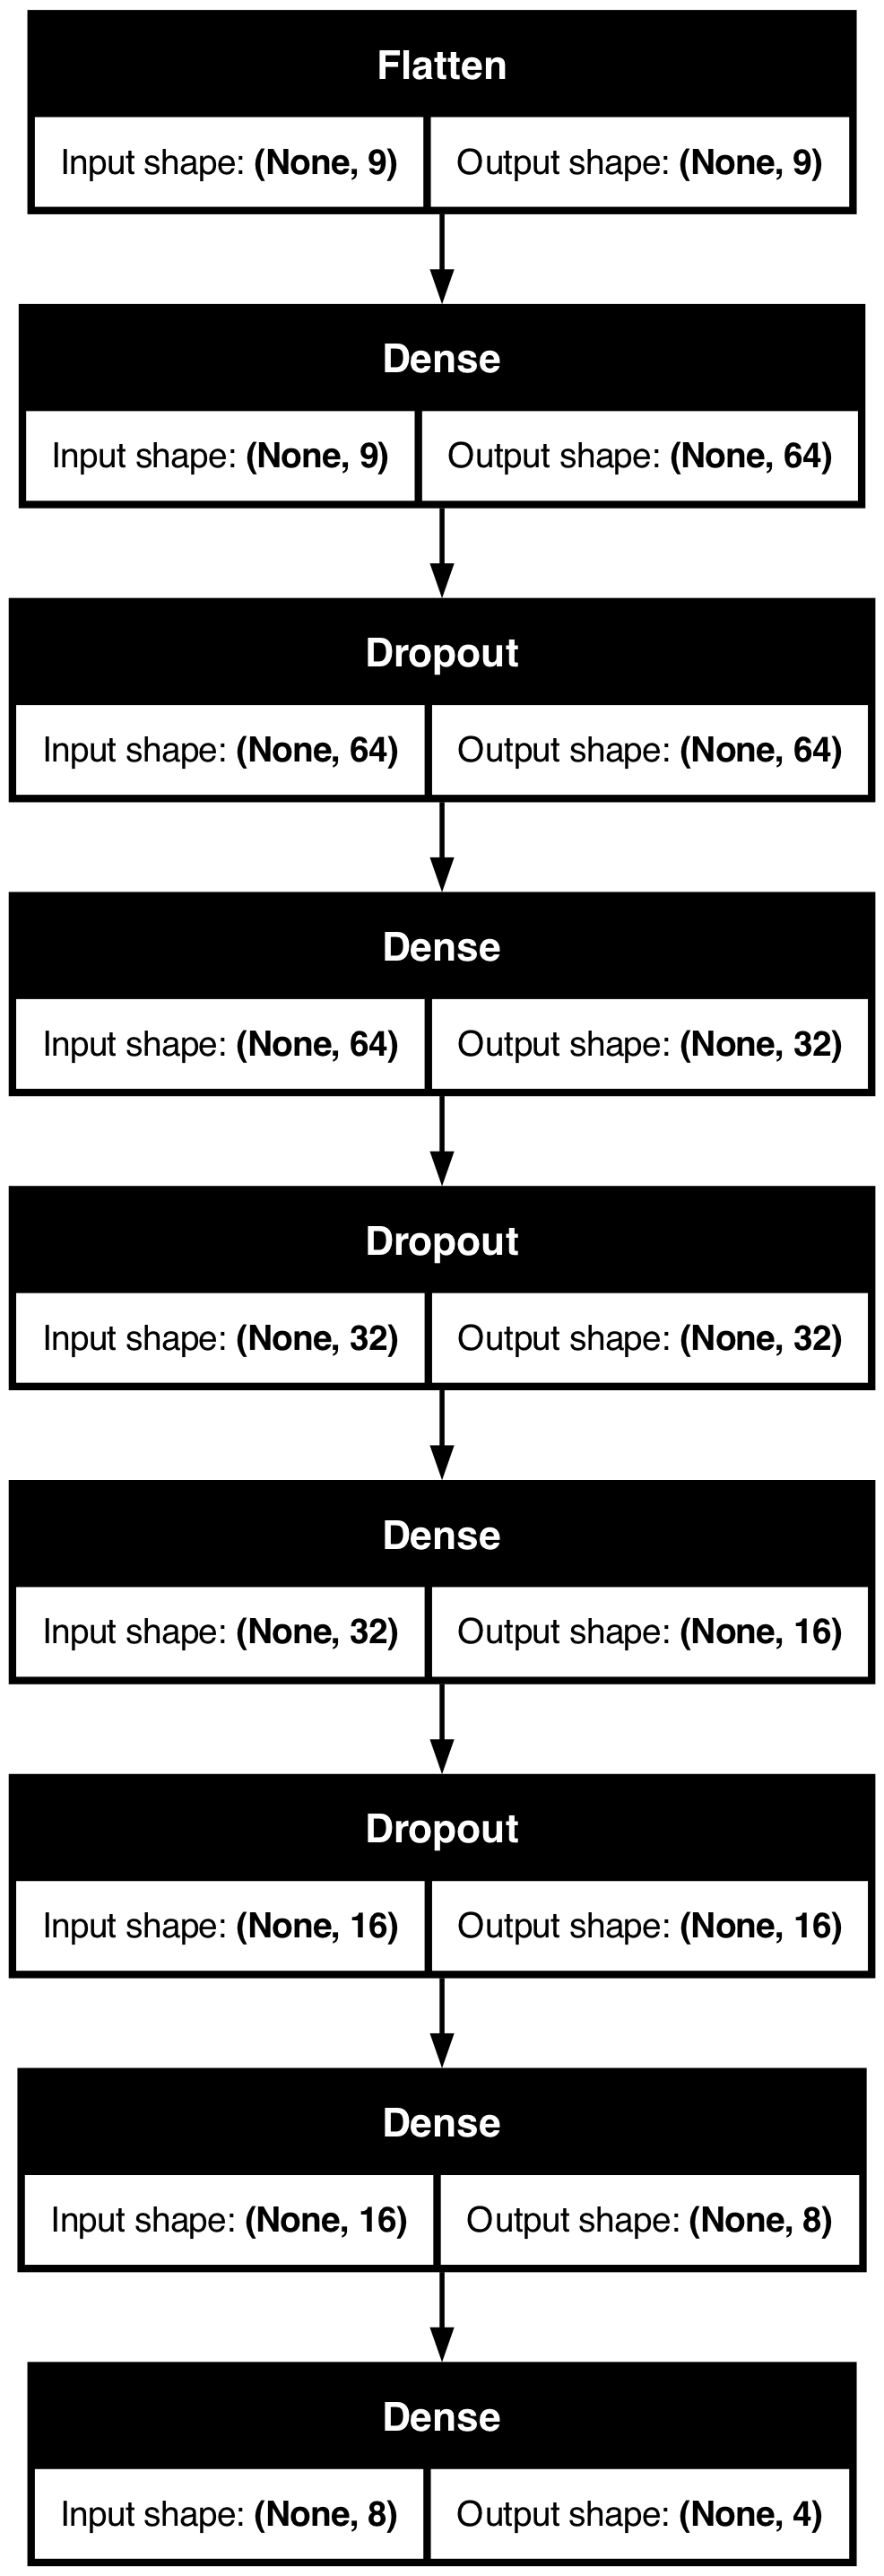

In [25]:
# modelling DNN

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(9, )), 
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [26]:
# compile

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# callback 설정 및 fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=500, 
                    validation_data=(X_val_scaled, y_val), verbose=0, 
                    callbacks=early_stopping_cb)

print (history.history)

{'accuracy': [0.6102941036224365, 0.6985294222831726, 0.7426470518112183, 0.7279411554336548, 0.7867646813392639, 0.7720588445663452, 0.779411792755127, 0.7867646813392639, 0.7720588445663452, 0.8088235259056091, 0.7867646813392639, 0.8014705777168274, 0.7573529481887817, 0.7720588445663452, 0.8014705777168274, 0.7867646813392639, 0.7867646813392639, 0.8014705777168274, 0.7720588445663452, 0.8014705777168274, 0.8161764740943909, 0.8161764740943909, 0.8161764740943909, 0.8308823704719543, 0.8161764740943909, 0.8161764740943909, 0.8088235259056091, 0.8235294222831726, 0.8382353186607361, 0.8308823704719543, 0.8308823704719543, 0.8235294222831726, 0.8161764740943909, 0.8529411554336548, 0.845588207244873, 0.845588207244873, 0.8308823704719543, 0.8308823704719543, 0.8529411554336548, 0.8235294222831726, 0.8676470518112183], 'loss': [1.2752389907836914, 1.219505786895752, 1.1589378118515015, 1.0784144401550293, 1.016387701034546, 0.9436728358268738, 0.9544273614883423, 0.8976174592971802, 0

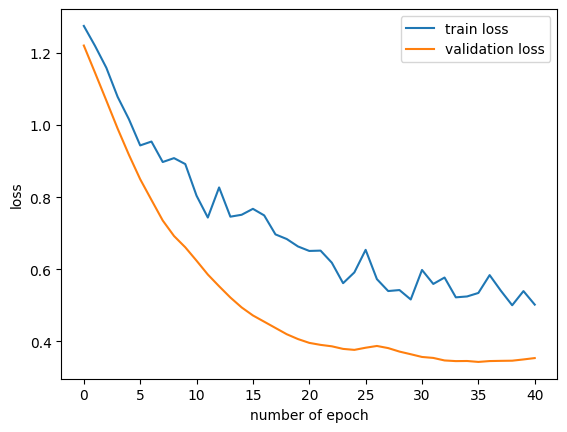

In [28]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

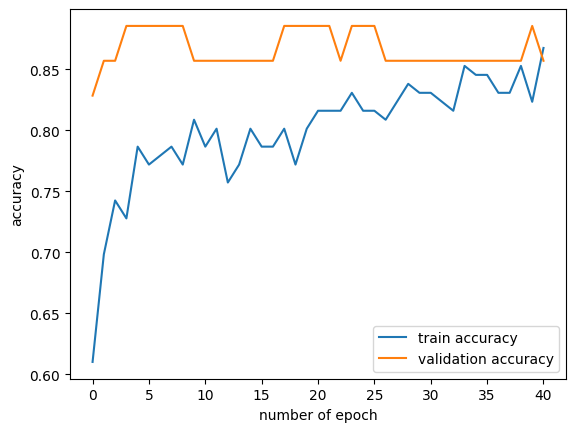

In [29]:
# accuracy 시각화

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.legend (['train accuracy', 'validation accuracy'])
plt.show() 

In [30]:
# train score, test score, val score

model_score = [model.evaluate(X_train_scaled, y_train), model.evaluate(X_test_scaled, y_test),
             model.evaluate(X_val_scaled, y_val)]
print (f"train score, test score, val score : {model_score}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8458 - loss: 0.4639 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7512 - loss: 0.8417 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8631 - loss: 0.3358 
train score, test score, val score : [[0.4440511465072632, 0.8602941036224365], [0.7796560525894165, 0.7674418687820435], [0.34293362498283386, 0.8571428656578064]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
***********DNN***********

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
predict result :  [[0.9588562  0.02225568 0.00944964 0.00943839]
 [0.96683604 0.01853338 0.0068481  0.00778247]
 [0.7037758  0.1514746  0.06058036 0.08416908]
 [0.9484167  0.02959746 0.00957258 0.01241324]
 [0.88760066 0.05996545 0.02305808 0.02937587]
 [0.7712757  0.10681299 0.05688175 0.06502955]
 [0.94378644 0.02971938 0.01198777 0.01450642]
 [0.00925939 0.01001582 0.05092017 0.92980456]
 [0.8839041  0.06104809 0.02798241 0.0270654 ]
 [0.45625052 0.17472063 0.23016633 0.13886243]
 [0.9834153  0.00880959 0.00488649 0.00288869]
 [0.928253   0.03813053 0.01695923 0.01665728]
 [0.34988034 0.17448351 0.16012183 0.31551427]
 [0.8142967  0.09104311 0.03941196 0.05524823]
 [0.91291517 0.04731479 0.01801519 0.02175477]
 [0.84757084 0.07644084 0.03398104 0.04200728]
 [0.94446117 0.03147058 0.01090636 0.01316202]
 [0.852606   0.07591581 0.03113947 0.04033867]
 [0.8053374  0.09421659 0.0489212

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

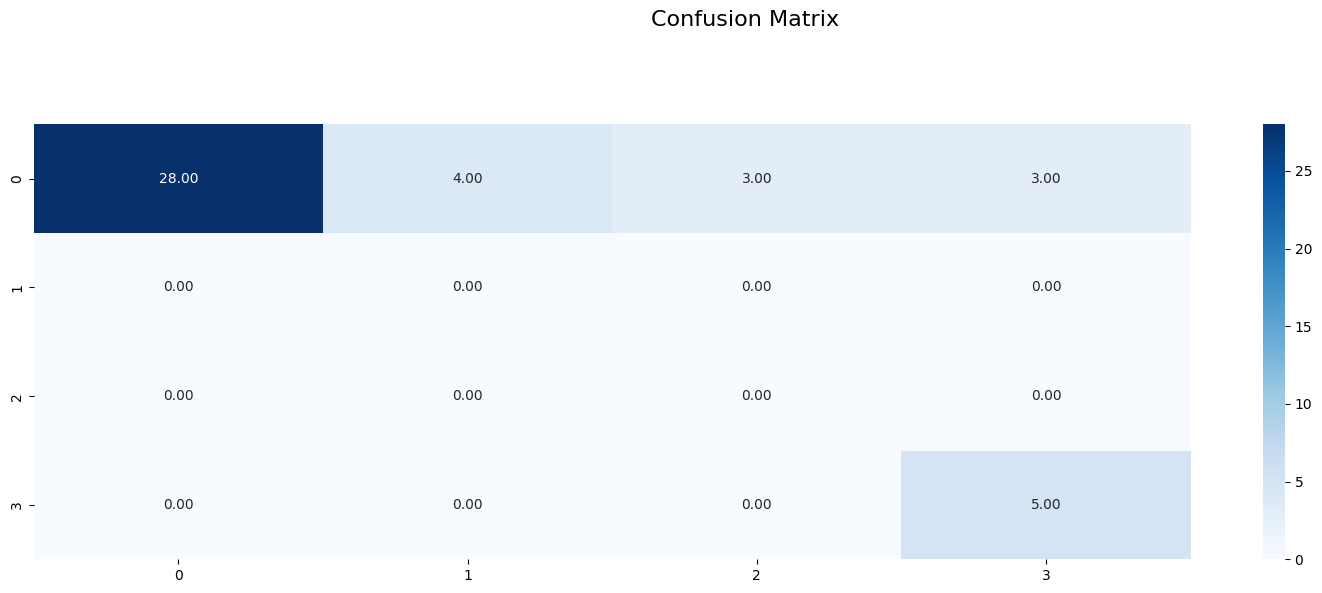

In [31]:
# classification report and confusion matrix (시각화)

y_pred = model.predict(X_test_scaled).argmax(axis=1) # 기억할 것, predict의 결과는 class별로의 확률
cm = confusion_matrix(y_pred, y_test)

print ("***********DNN***********")
print ()
print ("predict result : ", model.predict(X_test_scaled))
print ()
print("report :\n", classification_report(y_pred, y_test))
print (cm_1)

fig, axes = plt.subplots(figsize=(15, 6))

# heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')

fig.suptitle('Confusion Matrix\n\n', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

-------

### 5.  CNN (2D)
- convolution을 통하여 중요한 feature만 도드라지게 하여 학습을 진행한다.
- 일단은, CNN을 여기에 적용하기엔 부적합할 수 있다. 하지만 진행해보자면...
    - 3차원 tensor로 전환하여 Conv2D layer로 convolution을 시행할 수 있을 것 같다. 아래와 같이 전환한다.
        - 배치 크기 : row의 갯수
        - 세로 : 1 (관계형 데이터 csv이기 때문에 한 row를 기준으로)
        - 가로 : feature의 갯수 (col의 갯수)
        - 채널 : 1 (데이터를 단일 채널이라고 가정)
    - 전환 후 CNN 2d를 적용하여 main feature extraction 후 pooling을 진행한다.
    - Conv, pooling을 2번 반복 후 dense layer를 두어 classification한다.
        - 중간에 dropout 층을 배치하여 overfitting을 막고 학습에 신중하도록 한다.
        - compile 시 적응형 학습율 알고리즘을 사용하는 Adam optimizer로 사용하겠다.
- overfitting을 막기 위하여, DNN에서 했던 것과 같이 early stopping 콜백을 설치한다.

In [32]:
# X_train_scaled, X_test_scaled, X_val_scaled 데이터를 3차원 tensor로 전환한다.

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1], 1))
X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1], 1))

In [33]:
# shape 확인

X_train_cnn.shape, X_test_cnn.shape, X_val_cnn.shape

((136, 1, 9, 1), (43, 1, 9, 1), (35, 1, 9, 1))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1, 9, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1, 9, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1, 4, 16)       │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,572 (25.67 KB)

 Trainable params: 6,572 (25.67 KB)

 Non-trainable params: 0 (0.00 B)

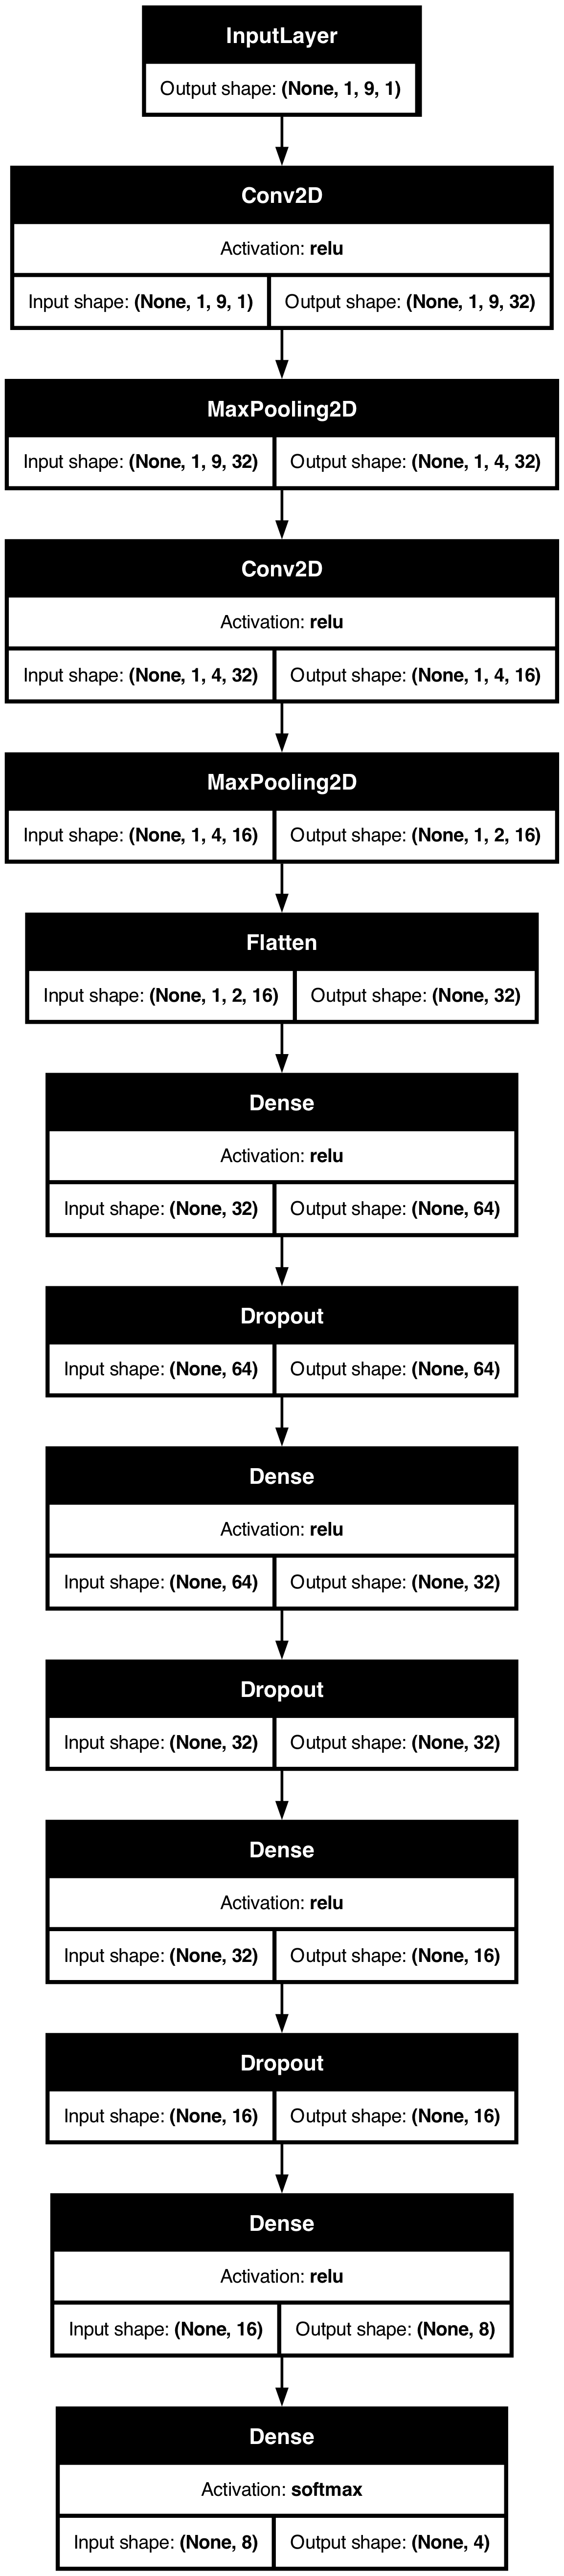

In [34]:
# modelling (functional API 방식)

input_layer = keras.Input(shape=(1, 9, 1))
conv_1 = keras.layers.Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same')(input_layer)
pooling_1 = keras.layers.MaxPooling2D((1, 2))(conv_1)
conv_2 = keras.layers.Conv2D(16, kernel_size=(1, 3), activation='relu', padding='same')(pooling_1)
pooling_2 = keras.layers.MaxPooling2D((1, 2))(conv_2)
flatten = keras.layers.Flatten()(pooling_2)
dense_1 = keras.layers.Dense(64, activation='relu') (flatten)
dropout_1 = keras.layers.Dropout(0.5) (dense_1)
dense_2 = keras.layers.Dense(32, activation='relu') (dropout_1)
dropout_2 = keras.layers.Dropout(0.5) (dense_2)
dense_3 = keras.layers.Dense(16, activation='relu') (dropout_2)
dropout_3 = keras.layers.Dropout(0.2) (dense_3)
dense_4 = keras.layers.Dense(8, activation='relu') (dropout_3)
output_layer = keras.layers.Dense(4, activation='softmax') (dense_4)

# model = keras.Model(
#     input_layer,
#     conv_1,
#     pooling_1,
#     conv_2,
#     pooling_2,
#     flatten,
#     dense_1,
#     dropout_1,
#     dense_2,
#     dropout_2,
#     dense_3,
#     output_layer
# )

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [35]:
# compile

adam = keras.optimizers.Adam()
model.compile (optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
# fit 

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, epochs=100, 
                    validation_data=(X_val_cnn, y_val), batch_size=30, 
                    callbacks=early_stopping_cb, 
                    verbose=0)

print (history.history)

{'accuracy': [0.1985294073820114, 0.375, 0.595588207244873, 0.654411792755127, 0.6617646813392639, 0.6691176295280457, 0.6838235259056091, 0.6985294222831726, 0.6691176295280457, 0.6691176295280457, 0.6764705777168274, 0.6691176295280457, 0.6911764740943909, 0.6838235259056091, 0.7058823704719543, 0.6838235259056091, 0.6764705777168274, 0.6838235259056091, 0.6838235259056091, 0.6838235259056091, 0.6691176295280457, 0.6838235259056091, 0.6764705777168274, 0.6764705777168274, 0.6838235259056091, 0.6838235259056091, 0.6838235259056091, 0.6838235259056091, 0.6838235259056091, 0.6911764740943909, 0.6838235259056091, 0.6838235259056091, 0.6985294222831726, 0.6985294222831726, 0.6985294222831726, 0.6838235259056091, 0.6985294222831726, 0.6838235259056091, 0.7058823704719543, 0.6985294222831726, 0.7058823704719543, 0.7132353186607361, 0.720588207244873, 0.7132353186607361, 0.7352941036224365, 0.720588207244873, 0.6985294222831726, 0.7573529481887817, 0.7647058963775635, 0.75, 0.75, 0.772058844

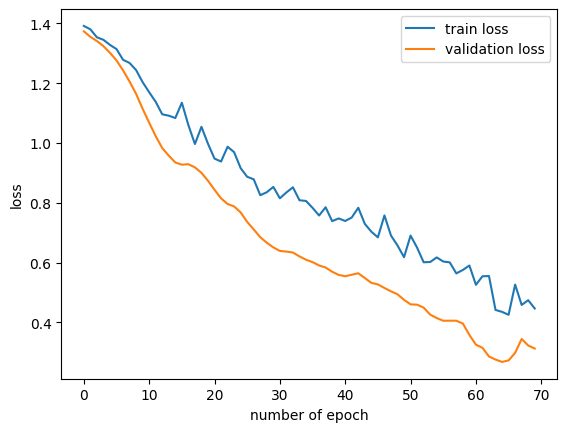

In [37]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

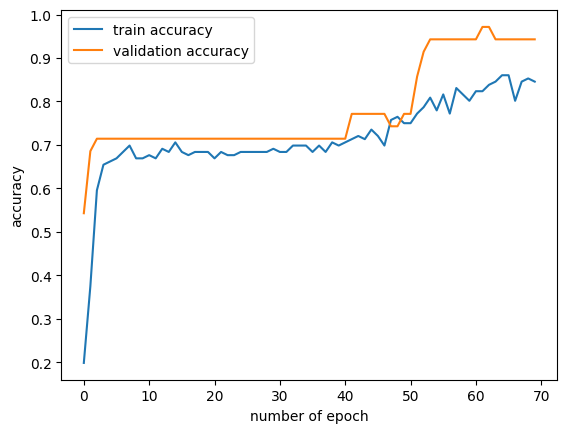

In [38]:
# accuracy 시각화

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.legend (['train accuracy', 'validation accuracy'])
plt.show() 

In [39]:
# train score, test score, val score

model_score = [model.evaluate(X_train_cnn, y_train), model.evaluate(X_test_cnn, y_test),
             model.evaluate(X_val_cnn, y_val)]
print (f"train score, test score, val score : {model_score}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8790 - loss: 0.3912 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7926 - loss: 0.8138 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9411 - loss: 0.2734 
train score, test score, val score : [[0.36186307668685913, 0.8897058963775635], [0.7527065873146057, 0.8139534592628479], [0.2682153582572937, 0.9428571462631226]]


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1364353a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
***********CNN***********

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
predict result :  [[9.88713920e-01 5.22783725e-03 5.49617398e-04 5.50859794e-03]
 [9.64035213e-01 1.58860311e-02 1.92455959e-03 1.81541350e-

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

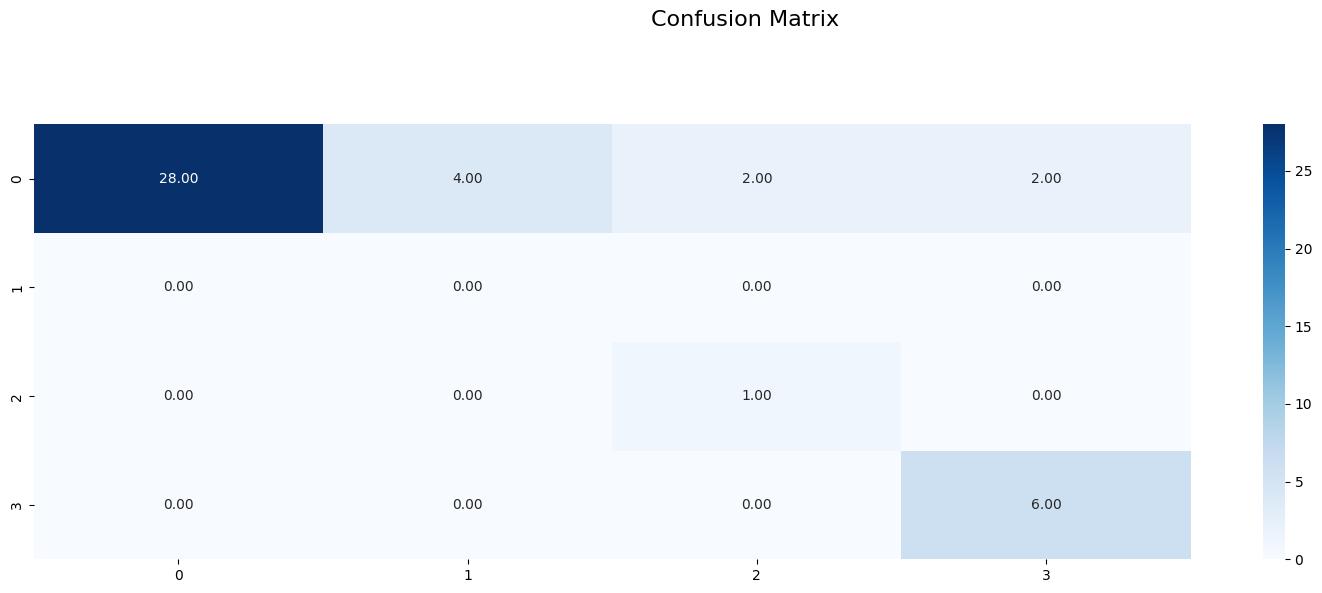

In [40]:
# classification report and confusion matrix (시각화)

y_pred = model.predict(X_test_cnn).argmax(axis=1) # 기억할 것, predict의 결과는 class별로의 확률
cm = confusion_matrix(y_pred, y_test)

print ("***********CNN***********")
print ()
print ("predict result : ", model.predict(X_test_cnn))
print ()
print("report :\n", classification_report(y_pred, y_test))
print (cm)

fig, axes = plt.subplots(figsize=(15, 6))

# heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')

fig.suptitle('Confusion Matrix\n\n', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()